# Open American Standard Version

The OASV is an English translation of the Bible with very high literal fidelity to the Textus Receptus and modern English phrasing. Importantly, the OASV is completely open source! The full text is free to use, free to print and free to modify. Better yet, not only is the finished text freely available, but so is the entire methodology for its generation. The code here can be used to completely replicate this text from scratch, starting with the original 1901 American Standard Version and ending with a beautiful modern translation. I hope you gain something from the code presented here, but I hope even more that you benifit from reading, sharing and building upon this modern translation of the free and open Bible.

## Getting Started

First things first, we need to install and import various python libraries, establish our file structure, and set up our environment for generating, storing and validating the text of the OASV.

In [ ]:
%pip install --upgrade openai

from openai import OpenAI
import os
import time
import random
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

## Set the API key and model name
OPENAI_API_KEY="insert-key-here"
MODEL="gpt-4o"
client = OpenAI(api_key=OPENAI_API_KEY)

## mount google Drive and Create OASV folder
drive.mount('/content/drive')
OASV_path = f"/content/drive/My Drive/OASV"
if not os.path.exists(OASV_path):
  os.makedirs(OASV_path)

## write the similarity score file
similarity_scores_path = f"{OASV_path}/similarity_scores"
if not os.path.exists(similarity_scores_path):
  with open(similarity_scores_path, "w") as f:
    f.write(f"verse, ASV, NIV, NASB\n")

## Defining the ChatGPT models

The heart of the OASV Translation methodology is the chatGPT-4o Large Language Model (LLM). This model is incredibly powerful, and we use it here to surgically remove the archaic language from the original 1901 ASV text. We also use the LLM for quality control, both to ensure that the generated text includes all the verses of the original and to ensure that the verses themselves are true to the original ASV and not plagarisms of other modern translations.

In [9]:
def gen_OASV_Chapter(book, chapter):
  # Use ChatGPT to build one chapter of the OASV Bible
  system_role = '''Please modernize the ASV translation of the Bible according to the following strict guidelines:
                 Retain the exact wording and sentence structures of the ASV as closely as possible—only modernizing archaic words and awkward phrasings.
                    * Replace all archaic pronouns, tranistions and prepositions (thee, thou, ye, verily, hereof, hereof, unto, etc).
                    * Replace all archaic nouns (householder, lading, bretheren, kindred, dayspring, salutation, ministration, tumult, variance, countenance, supplication, etc)
                    * Replace all archaic verbs (begat, proceedeth, beesech, dwelt, shalt, platted, etc).
                    * Modernize awkward word placement (then was Jesus led, will be given you, if therefore, afterward to be spoken, according as his work is, if it be, of a surety, who am old, etc).
                    * Modernize archaic negative constructions (knew her not, answered nothing, fear them not, etc).
                    * DO NOT alter any punctuation markings, quotation markings or capitalizations.
                    * DO NOT alter the text based on other translations.
                    * DO NOT introduce wording from other translations—only replace outdated language with modern equivalents while keeping the ASV's structure intact.
                    * Output each verse on its own line, with each verse marked in the following format: [book.chapter.verse], e.g., [lk.1.1].
                    * Output the first line of text with the Chapter name, e.g., Matthew 1.
                 Please apply these rules strictly and consistently across all chapters!'''

  print(f"Processing {book} {chapter}... ", end="")
  completion = client.chat.completions.create(
    model=MODEL,
    messages=[
      {"role": "system", "content": system_role}, # <-- This is the system message that provides context to the model
      {"role": "user", "content": f"{book} {chapter}"}  # <-- This is the user message for which the model will generate a response
    ]
  )
  chapter_text = completion.choices[0].message.content

  # Save the output and return
  file_path = f"{OASV_path}/_{book}"
  file_name = f"{book}_{chapter:03}"
  save_text_to_file(file_path, file_name, chapter_text)
  print(f"Saved file to {file_path}/{file_name}")
  return chapter_text


In [10]:
def get_Chapter_Length(book, chapter, retries=3):
  # Use ChatGPT to check one verse of the OASV Bible
  system_role = '''Return the number of verses in [Book] [Chapter] as an integer. DO NOT output any other text.
                For example:
                - Input: Matthew 6
                - Output: 34'''

  for attempt in range(retries):
    try:
      completion = client.chat.completions.create(
        model=MODEL,
        messages=[
          {"role": "system", "content": system_role}, # <-- This is the system message that provides context to the model
          {"role": "user", "content": f"{book} {chapter}"}  # <-- This is the user message for which the model will generate a response
        ]
      )
      chapter_length = int(completion.choices[0].message.content)
      return chapter_length
    except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print("Retrying...")
            # Add a small delay before retrying
            time.sleep(2) # Import time module if not already present
        else:
            print("Max retries exceeded. Skipping this chapter.")
            return None # Or handle the error as needed


In [11]:
def check_Verse_Quality(text):
  # Use ChatGPT to check one verse of the OASV Bible
  system_role = '''Compare the given Bible verse to the American Standard Version (ASV), New International Version (NIV), and New American Standard Bible (NASB).
                 Assign a similarity score between 0 and 100 for each translation based on wording and structure.
                 ** If the provided text does not match the referenced verse, return 0,0,0.
                 ** Output only three integers separated by commas (e.g., 98,85,95).
                 ** If '--v' is included at the end, enable verbose mode, please provide the text of ASV, NIV, and NASB for the verse and explain the rationale for each similarity score.'''

  completion = client.chat.completions.create(
    model=MODEL,
    messages=[
      {"role": "system", "content": system_role}, # <-- This is the system message that provides context to the model
      {"role": "user", "content": text}  # <-- This is the user message for which the model will generate a response
    ]
  )

  try:
    verse_id = text.split()[0]
    verse_score = completion.choices[0].message.content
  except:
    verse_id = "unk"
    verse_score = "0,0,0"

  print(f"{verse_score} -- {text}")
  with open(similarity_scores_path, "a") as f:
    f.write(f"{verse_id},{verse_score}\n")
  return


In [12]:
def save_text_to_file(folder_path, file_name, text_content):
    # Define the full file path
    file_path = f"{folder_path}/{file_name}"

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the text to the file
    with open(file_path, "w") as f:
        f.write(text_content)



def check_Chapter_length(book, chapter, chapter_text):
    chapter_verses = [verse for verse in chapter_text.split('\n') if verse.startswith('[')]

    # Check to ensure the whole Chapter was generated
    chapter_length = get_Chapter_Length(book, chapter)
    generated_length = len(chapter_verses)

    if generated_length < chapter_length:
      print(f"Warning: {book} {chapter} has {generated_length}/{chapter_length} verses")
      additional_text = gen_OASV_Chapter(book, f"{chapter}:{generated_length+1}")
      chapter_text += additional_text

    return chapter_text




def check_Chapter_Quality(chapter_text, num_verses_to_check):
  """
  Splits a string by carriage returns, randomly selects a specified number of lines,
  and processes each selected line using a placeholder function.

  Args:
    chapter_text: The input string to be split.
    num_verses_to_check: The number of lines to randomly select.
    placeholder_function: The function to apply to each selected line.
  """
  verses = chapter_text.split('\n')
  verses = [verse for verse in verses if verse.startswith('[')]
  selected_verses = random.sample(verses, num_verses_to_check)

  for verse in selected_verses:
    check_Verse_Quality(verse) # Call the check_OASV_Verse function with each selected verse




In [13]:
def gen_OASV_Book(book, chapters, retries = 3):
  my_book_text = ""

  for ch in range(118, chapters + 1):

    for attempt in range(retries):
      try:
        chapter_text = gen_OASV_Chapter(book, ch)
        chapter_text = check_Chapter_length(book, ch, chapter_text)
        check_Chapter_Quality(chapter_text, 3)
        break

      except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print("Retrying...")
            # Add a small delay before retrying
            time.sleep(2) # Import time module if not already present
        else:
            print("Max retries exceeded. Skipping this chapter.")
            return None # Or handle the error as needed

    my_book_text += chapter_text + "\n"


  # Save the text to the file
  file_name = f"{OASV_path}/{book}"
  with open(file_name, "w") as f:
    f.write(my_book_text)
  print(f"Saved file to {file_name}")

  return

## Generate the Text!

In [ ]:
OT_books = [
    ("Genesis", 50), ("Exodus", 40), ("Leviticus", 27), ("Numbers", 36),
    ("Deuteronomy", 34), ("Joshua", 24), ("Judges", 21), ("Ruth", 4),
    ("1 Samuel", 31), ("2 Samuel", 24), ("1 Kings", 22), ("2 Kings", 25),
    ("1 Chronicles", 29), ("2 Chronicles", 36), ("Ezra", 10), ("Nehemiah", 13),
    ("Esther", 10), ("Job", 42), ("Psalms", 150), ("Proverbs", 31),
    ("Ecclesiastes", 12), ("Song of Solomon", 8), ("Isaiah", 66),
    ("Jeremiah", 52), ("Lamentations", 5), ("Ezekiel", 48), ("Daniel", 12),
    ("Hosea", 14), ("Joel", 3), ("Amos", 9), ("Obadiah", 1), ("Jonah", 4),
    ("Micah", 7), ("Nahum", 3), ("Habakkuk", 3), ("Zephaniah", 3),
    ("Haggai", 2), ("Zechariah", 14), ("Malachi", 4)
]

NT_books = [
    ("Matthew", 28), ("Mark", 16), ("Luke", 24), ("John", 21), ("Acts", 28),
    ("Romans", 16), ("1 Corinthians", 16), ("2 Corinthians", 13), ("Galatians", 6),
    ("Ephesians", 6), ("Philippians", 4), ("Colossians", 4), ("1 Thessalonians", 5),
    ("2 Thessalonians", 3), ("1 Timothy", 6), ("2 Timothy", 4), ("Titus", 3),
    ("Philemon", 1), ("Hebrews", 13), ("James", 5), ("1 Peter", 5), ("2 Peter", 3),
    ("1 John", 5), ("2 John", 1), ("3 John", 1), ("Jude", 1), ("Revelation", 22)
]

books = OT_books + NT_books

for book, chapters in books:
  print(f"Processing {book}...")
  gen_OASV_Book(book, chapters)


## Quality Control Statistics

Finally, we examine the overal similarity scores between the OASV text and the ASV, NIV and NASB. We should expect to see the highest similarity to the ASV.

(70.0, 100.0)

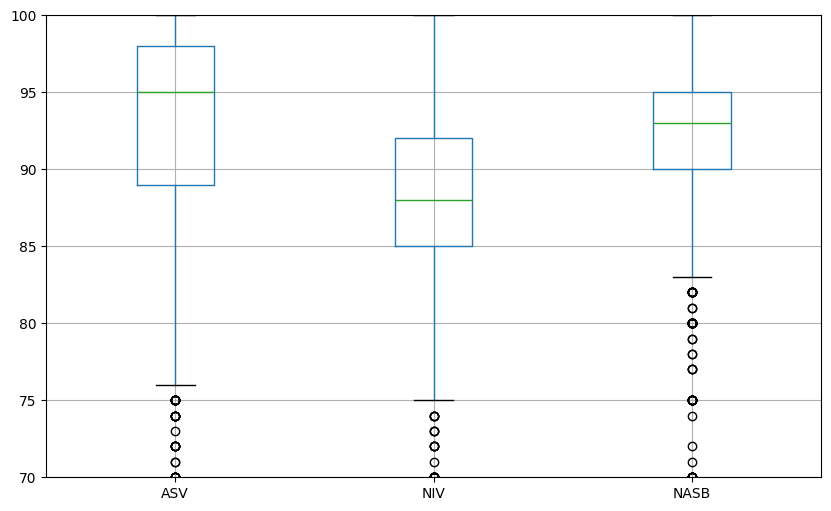

In [ ]:
df = pd.read_csv(similarity_scores_path, na_filter=False)
df.columns = df.columns.str.strip()
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors='coerce')
df[df.columns[2]] = pd.to_numeric(df[df.columns[2]], errors='coerce')
df[df.columns[3]] = pd.to_numeric(df[df.columns[3]], errors='coerce')
df = df.dropna(subset=[df.columns[3]])

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
boxplot = df.boxplot(column=['ASV', 'NIV', 'NASB'])
plt.ylim(70, 100)  # Set the y-axis limits from 0 to 100

In [ ]:
gen_OASV_Book('Psalms', 150)

In [17]:
def combine_chapters(book):
  book_text = ""
  directory = f"/content/drive/My Drive/OASV/_{book}"
  for filename in os.listdir(directory):
    with open(f"{directory}/{filename}", "r") as f:
      chapter_text = f.read()
    book_text += f"{chapter_text}\n"

  # Save the text to the file
  with open(f"{OASV_path}/{book}", "w") as f:
    f.write(book_text)

combine_chapters("Psalms")

In [ ]:
directory = "/content/drive/My Drive/OASV/_Psalms"
for filename in os.listdir(directory):
  _, num = filename.split("_")
  print(num)
  if len(num) != 3:
    new_filename = f"Psalms_0{num}"
    os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))